<h1>Gating Experiments: FMO KNN</h1>

In [1]:
from immunova.data.project import Project
from immunova.data.mongo_setup import global_init
from immunova.flow.gating.actions import Template
from tqdm import tqdm_notebook, tqdm
from functools import partial
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
global_init()

In [2]:
peritonitis = Project.objects(project_id='Peritonitis').get()

<h2>Create some populations using the T Panel</h2>

In [3]:
peritonitis.list_fcs_experiments()

['PBMC_T', 'PDMC_T', 'PBMC_M', 'PDMC_M']

In [4]:
pdmc_t = peritonitis.load_experiment('PDMC_T')

In [5]:
t_template = Template(experiment=pdmc_t, sample_id='pd318-01_t')

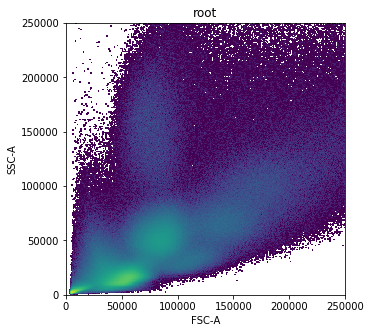

In [6]:
_ = t_template.plot_population('root', x='FSC-A', y='SSC-A')

<h3>Boundary gate</h3>

In [7]:
kwargs=dict(x_min=10000, x_max=125000, y_min=0, y_max=70000)
child_populations = dict(cells=dict(definition='+'))
t_template.create_gate(gate_name='cells', parent='root', x='FSC-A', y='SSC-A', 
                       func='rect_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

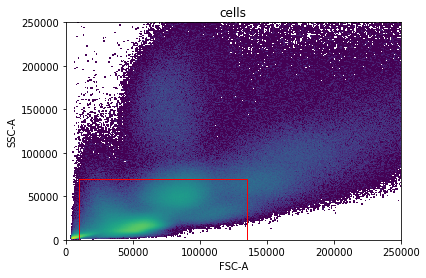

In [8]:
t_template.apply('cells')

<h3>Lymphocyte gate</h3>

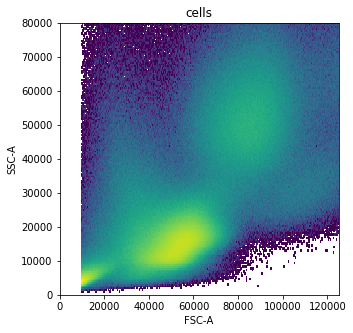

In [9]:
_ = t_template.plot_population('cells', x='FSC-A', y='SSC-A', xlim=(0,125000), ylim=(0,80000))

In [10]:
kwargs=dict(target=(50000,15000), k=4)
child_populations = dict(lymphocytes=dict(definition='+'))
t_template.create_gate(gate_name='lymphocytes', parent='cells',x='FSC-A', 
                       y='SSC-A', func='mm_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

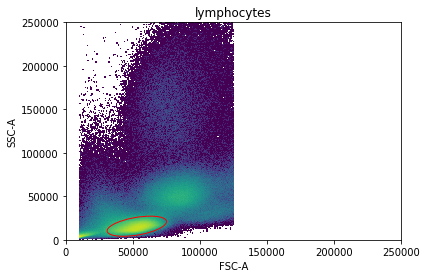

In [11]:
t_template.apply('lymphocytes')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f589c2f3fd0>)

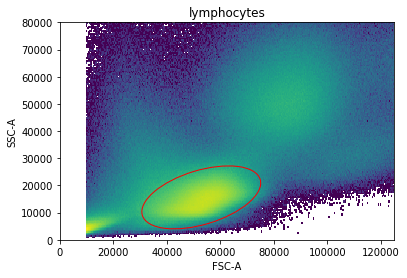

In [12]:
t_template.plot_gate('lymphocytes', xlim=(0,125000), ylim=(0,80000))

<h3>Singlet gate</h3>

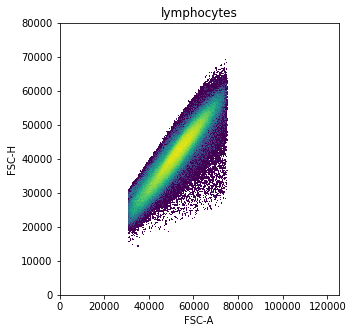

In [13]:
_ = t_template.plot_population('lymphocytes', x='FSC-A', y='FSC-H', xlim=(0,125000), ylim=(0,80000))

In [14]:
kwargs=dict(target=(60000,40000), k=2, conf=0.99)
child_populations = dict(singlets=dict(definition='+'))
t_template.create_gate(gate_name='singlets', parent='lymphocytes', x='FSC-A',
                      y='FSC-H', func='mm_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

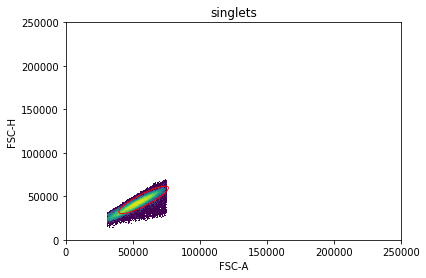

In [15]:
t_template.apply('singlets')

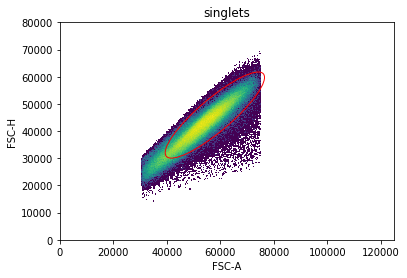

In [16]:
_ = t_template.plot_gate('singlets', xlim=(0,125000), ylim=(0,80000))

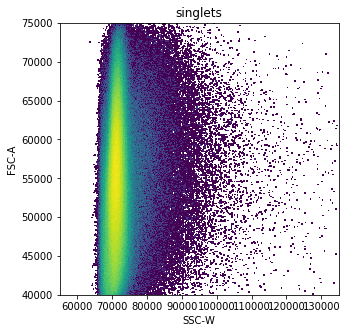

In [17]:
_ = t_template.plot_population('singlets', x='SSC-W', y='FSC-A', xlim=(55000,135000), ylim=(40000,75000))

In [18]:
kwargs=dict(q=0.95)
child_populations = dict(singlets_w=dict(definition='+'), doublets=dict(definition='-'))
t_template.create_gate(gate_name='singlets2', parent='singlets', x='SSC-W',
                       func='quantile_gate', func_args=kwargs, gate_type='threshold',
                      child_populations=child_populations)

True

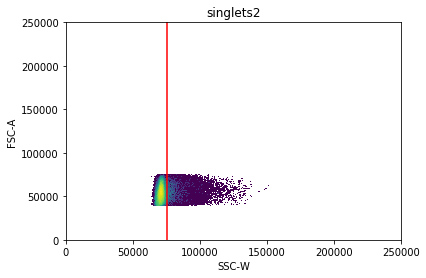

In [19]:
t_template.apply('singlets2')

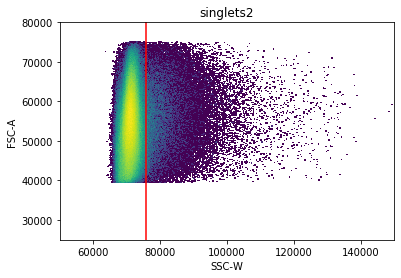

In [20]:
_ = t_template.plot_gate('singlets2', xlim=(50000,150000), ylim=(25000, 80000))

<h3>Live/Dead Gate</h3>

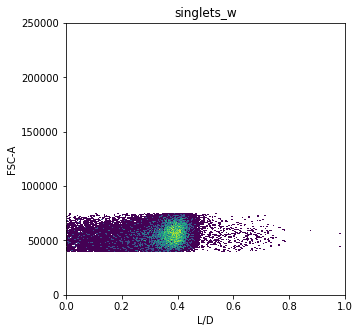

In [21]:
_ = t_template.plot_population('singlets_w', x='L/D', y='FSC-A')

In [22]:
kwargs=dict(q=0.99, kde_bw=0.1, kde_sample_frac=0.5, ignore_double_pos=True, 
            peak_threshold=0.05)
child_populations = dict(dead=dict(definition='+'), live=dict(definition='-'))
t_template.create_gate(gate_name='livedead_gate', parent='singlets_w', x='L/D',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom', child_populations=child_populations)

True

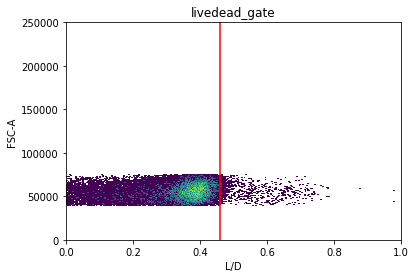

In [23]:
t_template.apply('livedead_gate')

<h3>T Cells (CD3+)</h3>

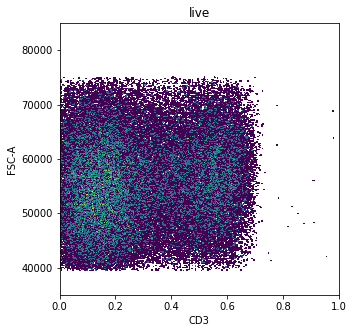

In [24]:
_ = t_template.plot_population('live', x='CD3', y='FSC-A', ylim=(35000,85000))

In [25]:
kwargs=dict(q=0.95, kde_bw=0.1, kde_sample_frac=1, ignore_double_pos=True, 
            peak_threshold=0.05)
child_populations = {'cd3+': dict(definition='+'), 'cd3-': dict(definition='-')}
t_template.create_gate(gate_name='cd3_gate', child_populations=child_populations, parent='live', x='CD3',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

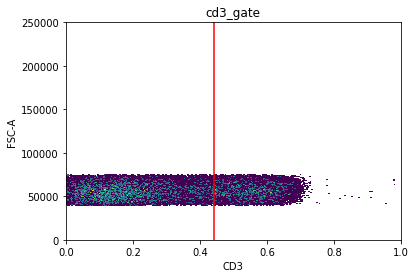

In [26]:
t_template.apply('cd3_gate')

<h3>Gamma Delta T cells</h3>

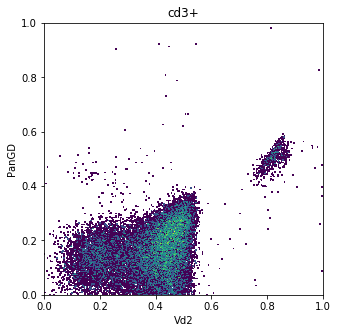

In [27]:
_ = t_template.plot_population('cd3+', x='Vd2', y='PanGD')

In [28]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, core_only=False)
child_populations={'gdt': {'target': (0.9, 0.6)},
                      'vd2-': {'target': (0.2, 0.6)},
                      'non_gdt': {'target': (0.3, 0.1)}}
t_template.create_gate(gate_name='gdt_gate', child_populations=child_populations, parent='cd3+', x='Vd2',
                       y='PanGD', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

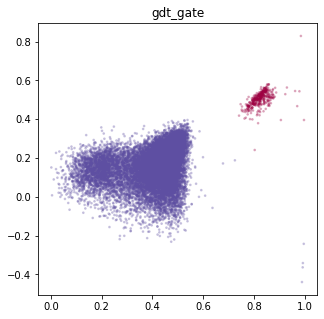

In [29]:
t_template.apply('gdt_gate')

<h3>MAITs</h3>

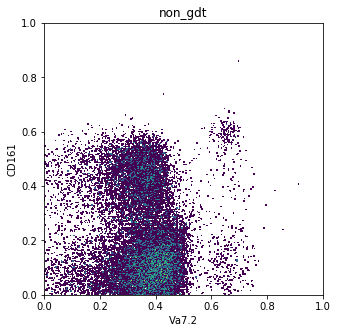

In [30]:
_ = t_template.plot_population('non_gdt', x='Va7.2', y='CD161')

In [31]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, core_only=False)
child_populations={'mait': {'target': (0.9, 0.6)},
                   'classic_tcells': {'target': (0.2, 0.2)}}
t_template.create_gate(gate_name='mait_gate', child_populations=child_populations, parent='non_gdt', x='Va7.2',
                       y='CD161', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

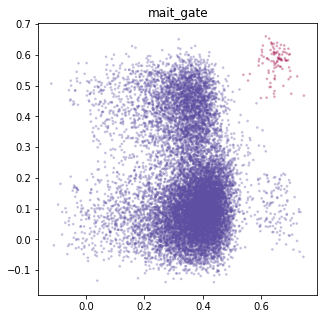

In [32]:
t_template.apply('mait_gate')

<h3>Classic T cells</h3>

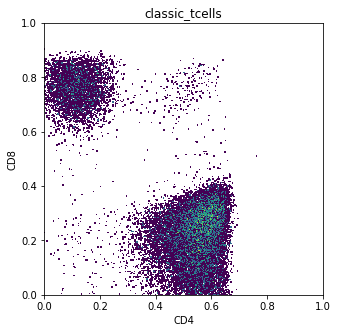

In [33]:
_ = t_template.plot_population('classic_tcells', x='CD4', y='CD8')

In [34]:
kwargs=dict(min_pop_size=10, distance_nn=0.05, core_only=False)
child_populations={'cd4': {'target': (0.8, 0.2)},
                   'cd8': {'target': (0.2, 0.8)}}
t_template.create_gate(gate_name='cd4cd8_gate', child_populations=child_populations, parent='classic_tcells', 
                       x='CD4', y='CD8', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

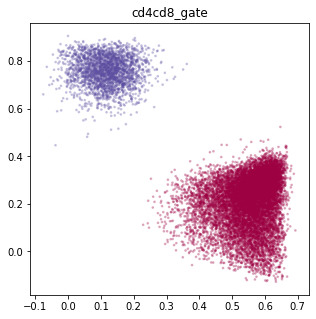

In [35]:
t_template.apply('cd4cd8_gate')

In [36]:
#data = t_template.data.copy()
#data.to_csv('experiment_data/data/pd318_10.csv')

In [45]:
t_template.fmo['pd318-01_t_CXCR3'].to_csv('experiment_data/data/pd318_10_CXCR3.csv')

In [37]:
import pickle
with open('experiment_data/data/pd318_10_pops.pickle', 'wb') as f:
    pickle.dump(t_template.populations, f)

<h2>Iterative KNN gating</h2>

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from datetime import datetime
import pickle
import numpy as np

In [44]:
x = pd.DataFrame(np.random.rand(100000, 2), columns=['a', 'b'])

In [45]:
mask = x[x.a > 0.4].index.values

In [48]:
%timeit x.iloc[mask]

1.17 ms ± 80 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
%timeit x[x.index.isin(mask)]

4.39 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
data = pd.read_csv('experiment_data/data/pd318_10.csv')
fmo_data = pd.read_csv('experiment_data/data/pd318_10_CXCR3.csv')
with open('experiment_data/data/pd318_10_pops.pickle', 'rb') as f:
    populations = pickle.load(f)

<h3>Calculate optimal parameters</h3>

In [37]:
features = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W',
            'CXCR3', 'CD161', 'CD3', 'CCR7', 'L/D', 'Va7.2', 'CD8', 'Vd2', 'CD45RA',
            'PanGD', 'CD4', 'CD27']

In [65]:
def get_tree(pop_name, route):
    if pop_name != 'root':
        route.append(pop_name)
        return get_tree(populations[pop_name]['parent'], route)
    return route
def knn_find_population(pop_name, fmo_data):
    tree = get_tree(pop_name, [])[::-1]
    fmo_data = fmo_data.copy()
    data_cache = None
    for p in tree:
        parent = populations[p]['parent']
        if data_cache is not None:
            X = data_cache.loc[populations[parent]['index']].copy()
        else:
            X = data.loc[populations[parent]['index']].copy()
        data_cache = X
        x = populations[p]['geom']['x']
        y = populations[p]['geom']['y']
        if not y:
            y = 'FSC-A'
        pos_idx = populations[p]['index']
        X['pos'] = 0
        X.pos = X.pos.mask(X.index.isin(pos_idx), 1)
        Y = X['pos']
        X = X[[x, y]]
        knn = KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree')
        knn.fit(X, Y)
        y_hat = knn.predict(fmo_data[[x, y]])
        fmo_data['pos'] = y_hat
        fmo_data = fmo_data[fmo_data.pos == 1]
    return fmo_data
    

In [66]:
%%timeit -n 1 -r 1
x = knn_find_population('mait', fmo_data)

5min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Add fmo index caching and plot the results

In [74]:
fmo = {'CXCR3' : {'data': fmo_data, 'index_cache': dict()}}

In [80]:
def population_tree(pop_name, route):
    if pop_name != 'root':
        route.append(pop_name)
        return get_tree(populations[pop_name]['parent'], route)
    return route
def knn_fmo(pop_name, fmo_name):
    # Population has previously been identified for this FMO
    if pop_name in fmo[fmo_name]['index_cache'].keys():
        d = fmo[fmo_name]['data']
        mask = fmo[fmo_name]['index_cache'][pop_name]
        return d.loc[mask]
    # Get population tree
    tree = population_tree(pop_name, [])[::-1]
    # Search FMO cache for existing FMO populations
    start = 0
    for i, p in enumerate(tree):
        if p in fmo[fmo_name]['index_cache'].keys():
            start = i
    if start > 0:
        fmo_data = fmo[fmo_name]['data'].loc[fmo[fmo_name]['index_cache'][tree[start]]].copy()
    else:
        fmo_data = fmo[fmo_name]['data'].copy()
    data_cache = None
    # Iterate over tree and calculate FMO populations
    for p in tree[start:]:
        parent = populations[p]['parent']
        if data_cache is not None:
            X = data_cache.loc[populations[parent]['index']]
        else:
            X = data.loc[populations[parent]['index']].copy()
        data_cache = X
        x = populations[p]['geom']['x']
        y = populations[p]['geom']['y']
        if not y:
            y = 'FSC-A'
        pos_idx = populations[p]['index']
        X['pos'] = 0
        X.pos = X.pos.mask(X.index.isin(pos_idx), 1)
        Y = X['pos']
        X = X[[x, y]]
        knn = KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree')
        knn.fit(X, Y)
        y_hat = knn.predict(fmo_data[[x, y]])
        fmo_data['pos'] = y_hat
        fmo_data = fmo_data[fmo_data.pos == 1]
        fmo[fmo_name]['index_cache'][p] = fmo_data.index.values
    return fmo_data

In [81]:
%%timeit -n 1 -r 1
x = knn_fmo('gdt', 'CXCR3')

6min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:
%%timeit -n 1 -r 1
x = knn_fmo('mait', 'CXCR3')

1.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [83]:
%%timeit -n 1 -r 1
x = knn_fmo('mait', 'CXCR3')

1.58 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
